### **4. California Housing Dataset** - Regression
- **Date**: Mar 14, 2024
- **Task**: Create a model to predict median house value
- **Procedure**: Analyze data with pandas, regression models with sklearn and catboost
- **Dataset source**: https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html
- **References**: https://scikit-learn.org/0.16/auto_examples/ensemble/plot_partial_dependence.html

In [2]:
# Step 0. Load libraries and custom modules
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
# Visualization --------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine Learning -----------------------------------------------------
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform, robust_scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import catboost as cb
import shap

/Users/alexismena/Documents/Data_Projects/Python/Model_Catalog/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Step 1. Load data and get a basic glimpse
# 1.1 Fetch data and show basic info
X, y = fetch_california_housing(return_X_y=True,as_frame=True)
df_raw = X.copy()
df_raw['MedHouseVal'] = y.copy()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [4]:
# 1.2 Get a sample
df_raw.sample(5, random_state=2024)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
11730,3.6530,13.0,6.418197,1.181135,3264.0,2.724541,38.98,-120.91,1.468
19197,3.9191,36.0,6.110063,1.059748,711.0,2.235849,38.45,-122.69,1.830
17032,4.5075,39.0,5.250986,1.042050,1744.0,2.291721,37.51,-122.27,3.649
14827,1.6389,37.0,3.733333,1.000000,1086.0,3.290909,32.66,-117.09,1.143
10577,4.9079,23.0,5.707510,1.027668,792.0,3.130435,33.63,-117.69,2.738


In [5]:
# Step 2. Transform the data if required
# 2.1 Create interim copy
df_interim = df_raw.copy()

In [6]:
# Step 3. Exploratory Data Analysis
# 3.1 Create data splits
df_train, df_test = train_test_split(df_interim.copy(), test_size=0.15, random_state=2024)

In [7]:
# 3.2 Get basic info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17544 entries, 14462 to 7816
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       17544 non-null  float64
 1   HouseAge     17544 non-null  float64
 2   AveRooms     17544 non-null  float64
 3   AveBedrms    17544 non-null  float64
 4   Population   17544 non-null  float64
 5   AveOccup     17544 non-null  float64
 6   Latitude     17544 non-null  float64
 7   Longitude    17544 non-null  float64
 8   MedHouseVal  17544 non-null  float64
dtypes: float64(9)
memory usage: 1.3 MB


In [8]:
# 3.3 Get basic statistics
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,17544.0,3.867749,1.889395,0.499900,2.565575,3.530350,4.742300,15.000100
HouseAge,17544.0,28.704571,12.572135,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,17544.0,5.422191,2.343423,0.846154,4.439083,5.227813,6.051620,132.533333
AveBedrms,17544.0,1.095891,0.456914,0.333333,1.005917,1.048980,1.099900,34.066667
Population,17544.0,1418.359325,1132.283797,3.000000,786.000000,1159.000000,1718.250000,35682.000000
AveOccup,17544.0,3.094981,11.260138,0.692308,2.429741,2.817800,3.278954,1243.333333
Latitude,17544.0,35.637617,2.136414,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,17544.0,-119.578793,2.005343,-124.350000,-121.810000,-118.500000,-118.010000,-114.310000
MedHouseVal,17544.0,2.067978,1.150197,0.149990,1.196750,1.799000,2.649250,5.000010


In [9]:
# 3.4 Sort to view extreme values
display(df_train.sort_values(by=['AveRooms'], ascending=False).head(5))
display(df_train.sort_values(by=['AveOccup'], ascending=False).head(5))

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1979,4.6250,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08,1.625
12447,1.6154,17.0,62.422222,14.111111,83.0,1.844444,33.97,-114.49,0.875
1913,4.0714,19.0,61.812500,11.000000,112.0,2.333333,39.01,-120.06,4.375
11862,2.6250,25.0,59.875000,15.312500,28.0,1.750000,40.27,-121.25,0.675
1912,4.9750,16.0,56.269231,10.153846,54.0,2.076923,39.01,-120.16,2.063


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
19006,10.2264,45.0,3.166667,0.833333,7460.0,1243.333333,38.32,-121.98,1.375
3364,5.5179,36.0,5.142857,1.142857,4198.0,599.714286,40.41,-120.51,0.675
16669,4.2639,46.0,9.076923,1.307692,6532.0,502.461538,35.32,-120.70,3.500
13034,6.1359,52.0,8.275862,1.517241,6675.0,230.172414,38.69,-121.15,2.250
9172,4.2391,5.0,5.123810,0.933333,8733.0,83.171429,34.47,-118.59,1.546


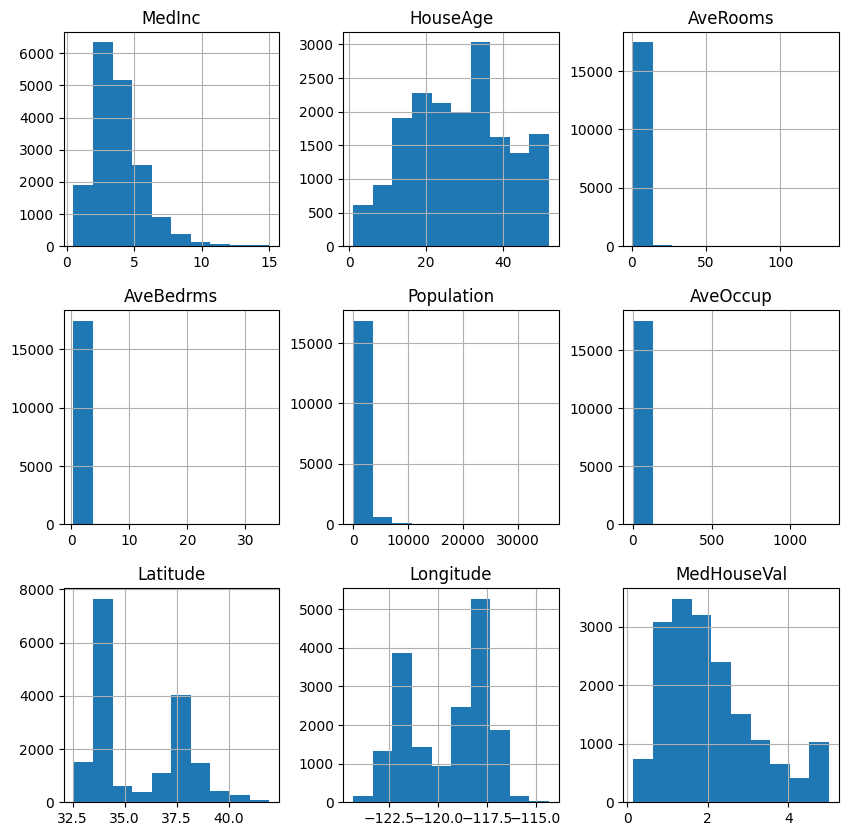

In [10]:
# 3.5 Univariate analysis - histograms
df_train.hist(figsize=(10,10))
plt.show()

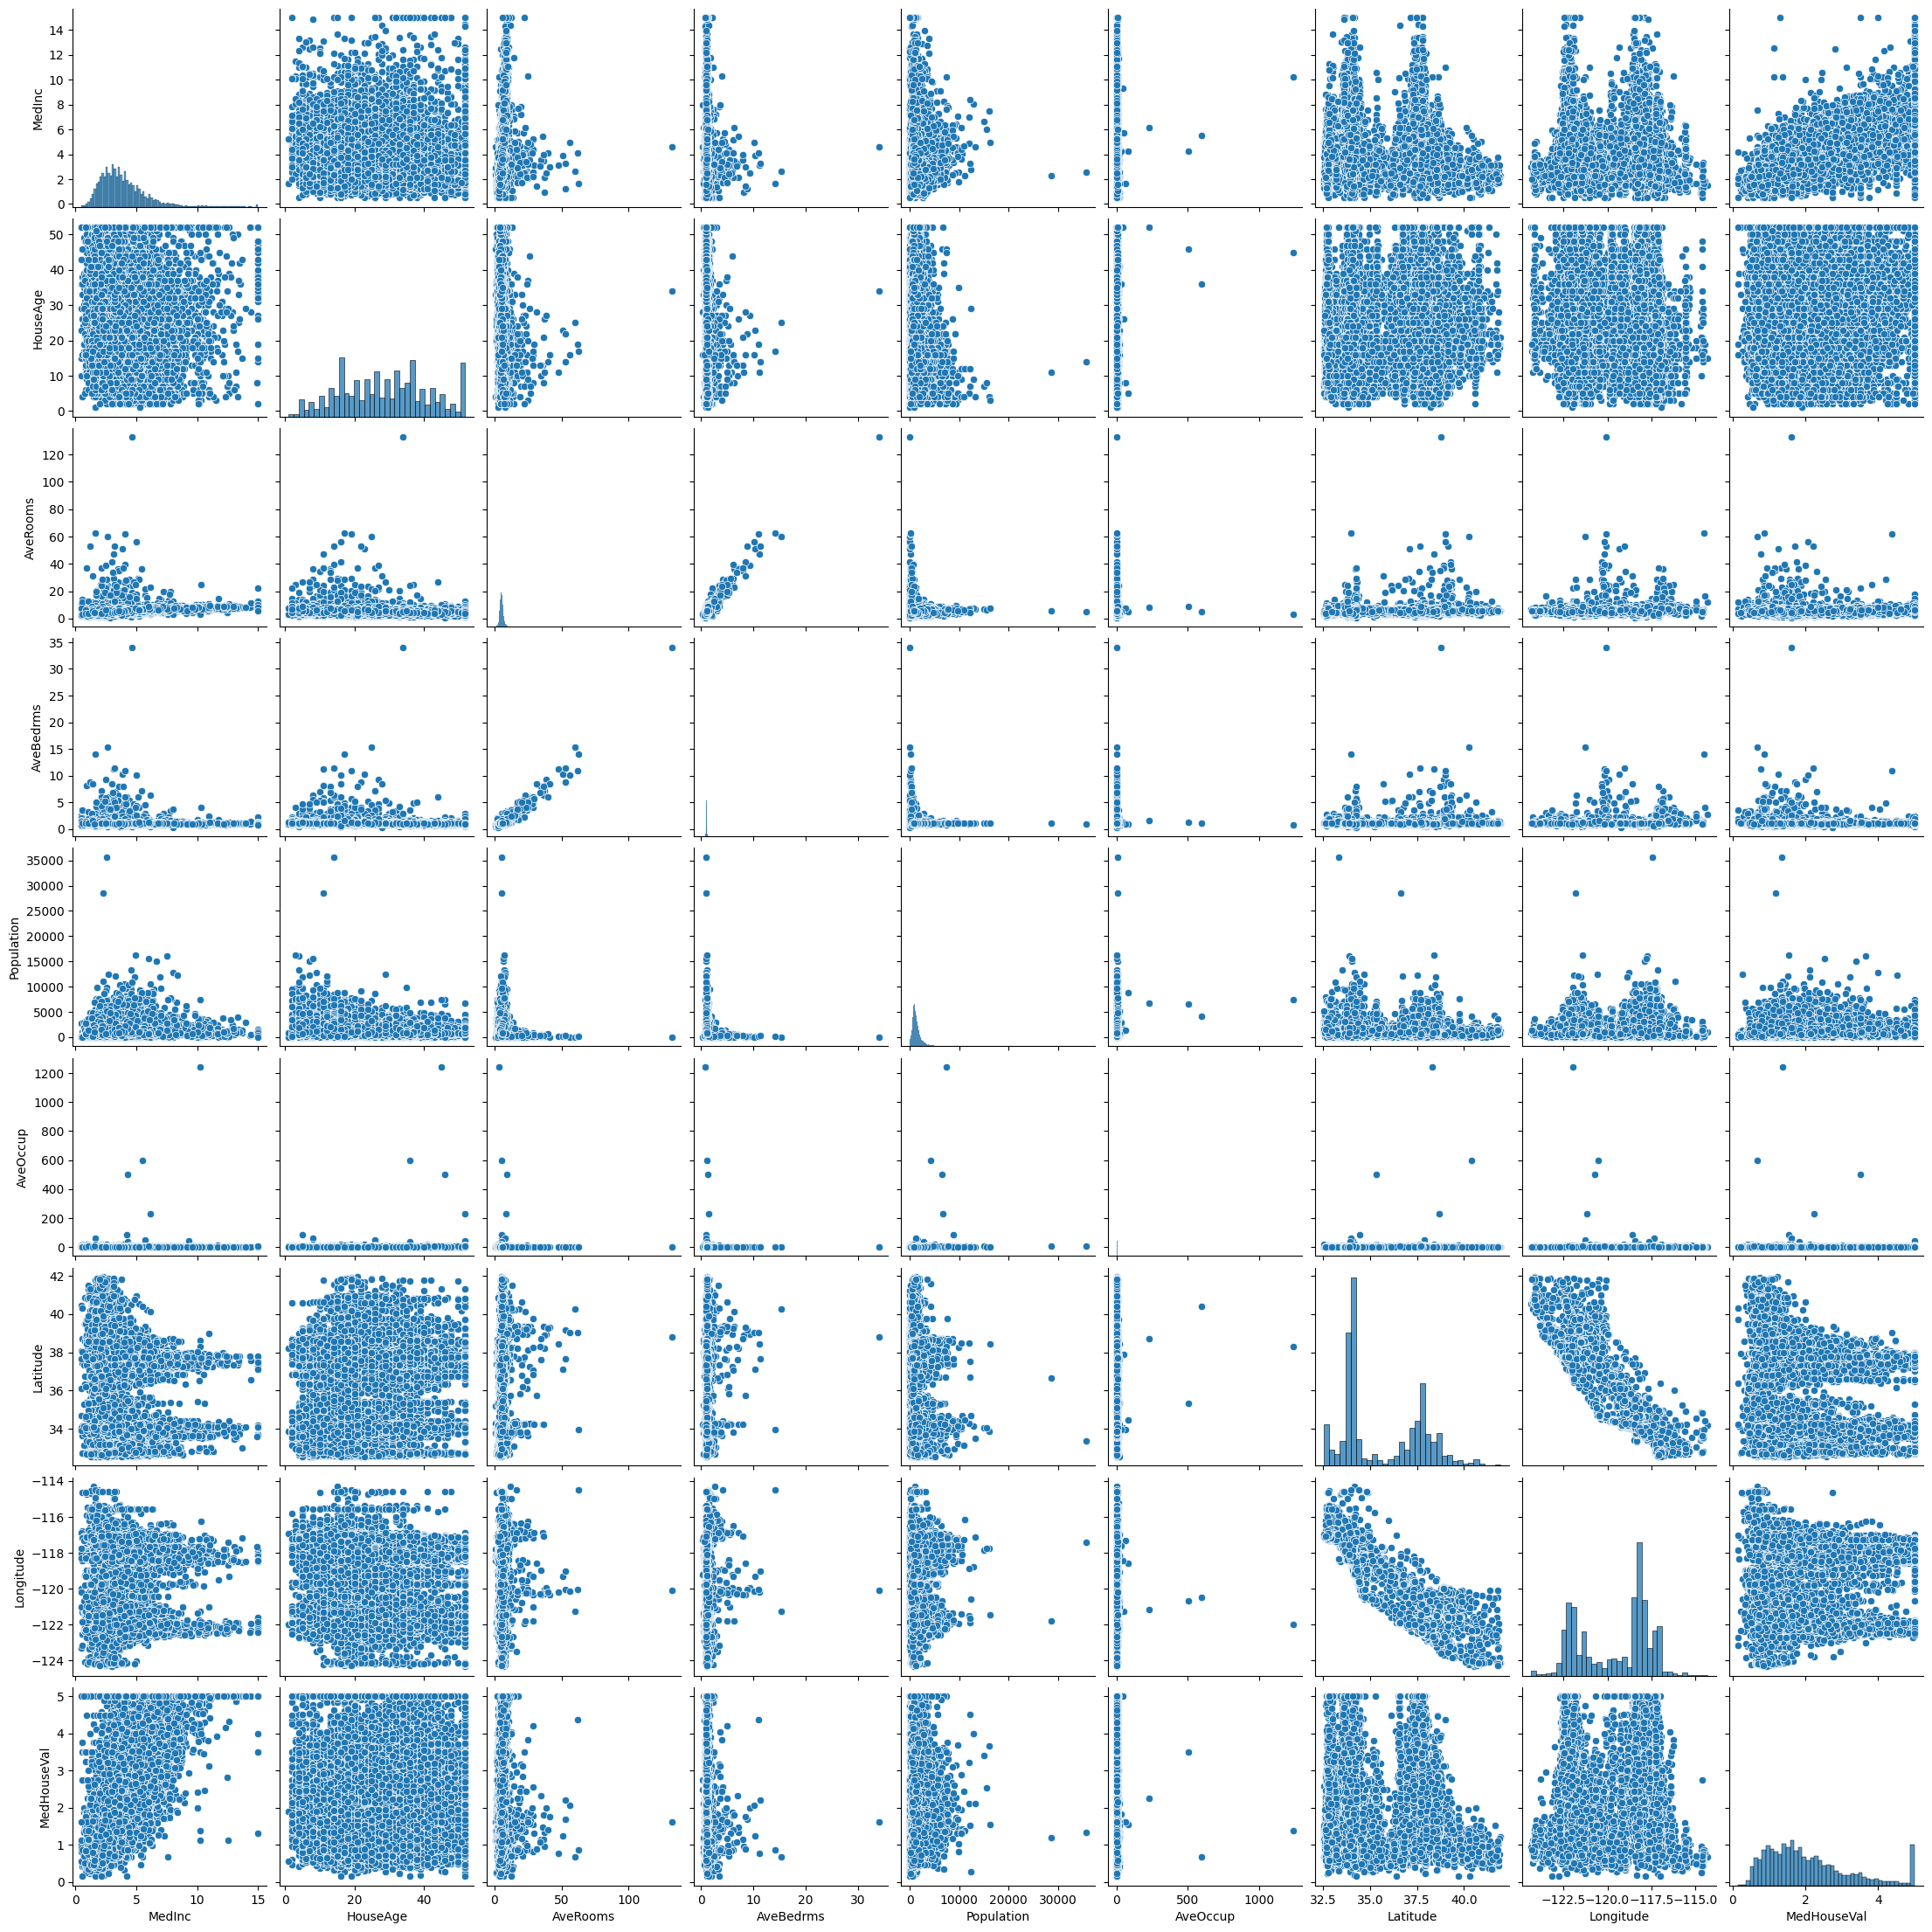

In [11]:
# 3.6 Bivariate analysis
sns.pairplot(df_train)
plt.show()

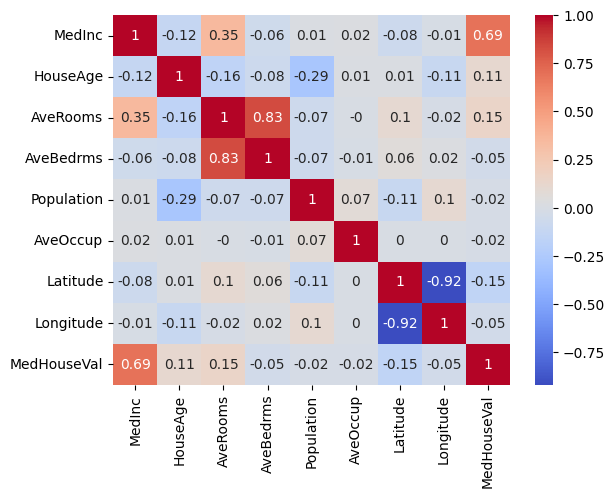

In [12]:
# 3.7 Analyze correlation
sns.heatmap(data=df_train.corr().round(2), annot=True, cmap='coolwarm')
plt.show()

In [13]:
# 3.8 Multicollinearity analysis
X_vif = df_train.drop(['MedHouseVal'], axis=1).assign(const=1)
vif = [variance_inflation_factor(X_vif, i) for i in range(len(X_vif.columns))]
df_vif = pd.DataFrame({'vif': vif}, index=X_vif.columns)
df_vif.sort_values('vif', ascending=False)

,vif
const,17263.541925
Latitude,9.442221
Longitude,9.084308
AveRooms,8.096563
AveBedrms,6.610758
MedInc,2.615964
HouseAge,1.239067
Population,1.136268
AveOccup,1.009565


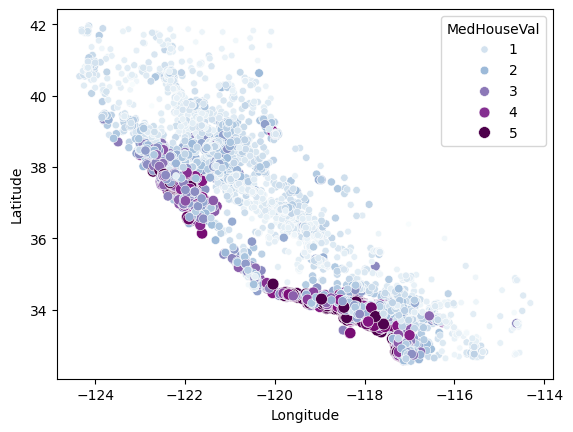

In [14]:
# 3.9 Spatial analysis
sns.scatterplot(df_train, x='Longitude',y='Latitude', hue='MedHouseVal', size='MedHouseVal', palette='BuPu')
plt.show()

In [15]:
X_train = df_train.drop(['MedHouseVal'],axis=1)
y_train = df_train['MedHouseVal']
X_test = df_test.drop(['MedHouseVal'], axis=1)
y_test = df_test['MedHouseVal']
train_dataset = cb.Pool(X_train, y_train)
test_dataset = cb.Pool(X_test, y_test)

In [16]:
model = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations':[100,150,200],
        'learning_rate':[0.03, 0.1],
        'depth':[2,3,4],
        'l2_leaf_reg':[0.2,0.5,1,3]}
model.grid_search(grid, train_dataset)

0:	learn: 2.3156481	test: 2.2676617	best: 2.2676617 (0)	total: 61.9ms	remaining: 6.13s
1:	learn: 2.2578521	test: 2.2105055	best: 2.2105055 (1)	total: 64.2ms	remaining: 3.14s
2:	learn: 2.2024595	test: 2.1555571	best: 2.1555571 (2)	total: 65.2ms	remaining: 2.11s
3:	learn: 2.1479075	test: 2.1015777	best: 2.1015777 (3)	total: 66.6ms	remaining: 1.6s
4:	learn: 2.0959008	test: 2.0499396	best: 2.0499396 (4)	total: 67.6ms	remaining: 1.28s
5:	learn: 2.0440977	test: 1.9982253	best: 1.9982253 (5)	total: 68.5ms	remaining: 1.07s
6:	learn: 1.9949157	test: 1.9492556	best: 1.9492556 (6)	total: 69.3ms	remaining: 921ms
7:	learn: 1.9480066	test: 1.9021093	best: 1.9021093 (7)	total: 71.4ms	remaining: 821ms
8:	learn: 1.9023901	test: 1.8568443	best: 1.8568443 (8)	total: 72.6ms	remaining: 734ms
9:	learn: 1.8575263	test: 1.8122944	best: 1.8122944 (9)	total: 73.6ms	remaining: 663ms
10:	learn: 1.8139816	test: 1.7689687	best: 1.7689687 (10)	total: 74.6ms	remaining: 603ms
11:	learn: 1.7722568	test: 1.7276031	best:

{'params': {'depth': 4,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2,
  'iterations': 200},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [17]:
from sklearn.metrics import mean_squared_error
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2_score = r2_score(y_test, pred)
print(f"RMSE: {rmse:.2f}, 'R2':{r2_score:.2f}")

RMSE: 0.51, 'R2':0.81


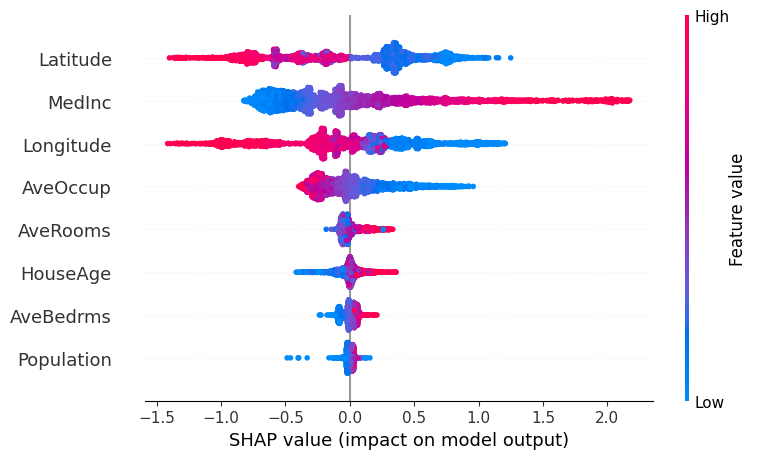

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
plt.show()

In [19]:
shap_values

array([[-0.10477244, -0.05428907,  0.04459577, ..., -0.02344506,
        -0.74495238,  0.24988432],
       [ 0.01345904,  0.02224775,  0.00452497, ...,  0.2144741 ,
        -0.91409183,  0.84753622],
       [ 0.24358017,  0.09061703, -0.06789315, ...,  0.29791721,
        -0.04769074,  0.77072881],
       ...,
       [-0.73048181,  0.04517969, -0.01548777, ...,  0.38539839,
        -0.88140464,  0.2201245 ],
       [-0.63684763,  0.01132101,  0.06565116, ..., -0.28828475,
         0.30628341,  0.06250872],
       [-0.6725599 ,  0.00949823, -0.02657847, ..., -0.0731517 ,
         0.74355066, -0.9805245 ]])

In [20]:
shap_values.shape

(3096, 8)

<Axes: ylabel='Latitude'>

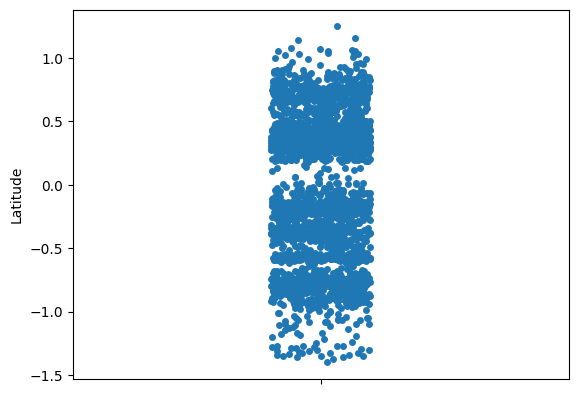

In [24]:
swarm = pd.DataFrame(data=shap_values, columns=X_test.columns)
sns.stripplot(data=swarm['Latitude']) 

In [25]:
tips = sns.load_dataset('tips')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


<Axes: >

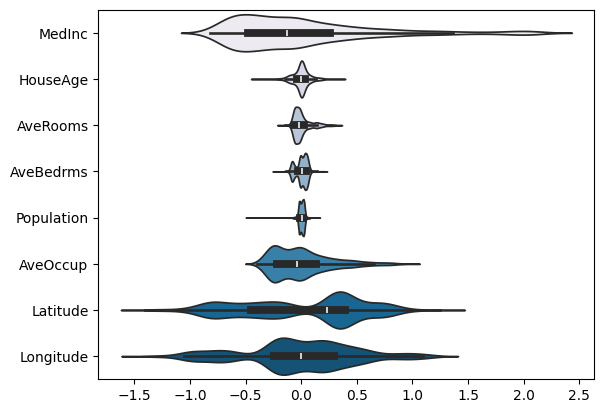

In [34]:
sns.violinplot(data=swarm, orient='h', palette='PuBu')